In [1]:
## NOTES ##
# TODO
# Get all of the code in one quick function 


In [2]:
import itertools
import json
import pickle
from pymongo import MongoClient
import seaborn as sns
from copy import deepcopy

import math
from textblob import TextBlob as tb
# from __future__ import division, unicode_literals

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from textblob import TextBlob

import nltk, string
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

from time import time

from scipy import sparse

import re
import random

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.lex_rank import LexRankSummarizer #We're choosing Lexrank, other algorithms are also built in

# Initial gensim summary
from gensim.summarization import summarize

pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

%matplotlib inline

In [3]:
from __future__ import unicode_literals

In [4]:
client = MongoClient()
# Sets db to the relationships database
db = client.relationships
# Access the submissions collection in the relationships database
submissions = db.relationships
# Access the documents in the collection
posts = db.submissions

In [5]:
# Check how many submissions I have so far - two ways
db.submissions.count()
posts.count()

38012

In [6]:
# A reminder of what keys are available in each document
doc = db.submissions.find_one()
for key in doc:
    print key

title
text
date
score
top_comment
_id
flair


In [7]:
# Put all of the posts/submissions into a list
question_list = []
for post in posts.find():
    question_list.append(post['text'])

# Put all of the answers/submissions into a list
answer_list = []
for post in posts.find():
    answer_list.append(post['top_comment'])

# List all of the dates
date_list = []
for post in posts.find():
    date_list.append(post['date'].date())


# List all of the times
time_list = []
for post in posts.find():
    time_list.append(post['date'].time().hour)


In [8]:
print date_list[:2]

[datetime.date(2016, 12, 31), datetime.date(2016, 12, 31)]


In [9]:
# Check that all the lengths are the same
print len(question_list)
print len(answer_list)
print len(date_list)
print len(time_list)

38012
38012
38012
38012


In [10]:
# Take away apostrophes
for q in question_list:
    q = q.replace("'", "")

# Take away apostrophes and drop Nones from posts that had no answer
answer_list = ['None' if a is None else a for a in answer_list]

for a in answer_list:
    a = a.replace("'", "")

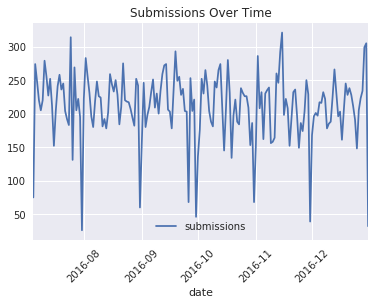

In [11]:
# Put the dates into a dataframe and plot
date_count = Counter(date_list)
date_count = pd.DataFrame(date_count.items())
date_count = date_count.rename(columns={0: 'date', 1: 'submissions'})
date_count.sort_values('date', inplace = True)
date_count.head()
ax = date_count.plot(x='date', y='submissions', rot=45, title = 'Submissions Over Time', )


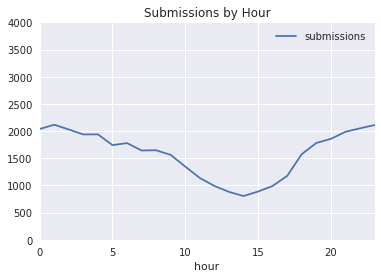

In [12]:
# Put the times into a dataframe and plot
time_count = Counter(time_list)
time_count = pd.DataFrame(time_count.items())
time_count = time_count.rename(columns={0: 'hour', 1: 'submissions'})
time_count.sort_values('hour', inplace = True)

# This is in UTC...maybe not that helpful 
time_count.plot(x='hour', y='submissions',  title = 'Submissions by Hour', ylim=(0,4000), xlim=(0,23))

# Preliminary Topic Modeling

In [13]:
stop_words = stopwords.words("english")

In [14]:
n_samples = 5000
n_features = 2000
n_topics = 5
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words=stop_words)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(question_list)
print("done in %0.3fs." % (time() - t0))


# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Extracting tf-idf features for NMF...
done in 16.503s.
Fitting the NMF model with tf-idf features, n_samples=5000 and n_features=2000...
done in 14.765s.

Topics in NMF model:
Topic #0:
like feel sex really want know things get time think relationship love much even life always people something make way
Topic #1:
mom dad family parents sister mother brother money father house home husband years school live job kids wife us pay
Topic #2:
said told asked night day back got time went would work go wanted week text going home phone days next
Topic #3:
friends friend girl best really guy group school people friendship like close know one hang girls feelings crush met guys
Topic #4:
relationship ex together broke months love girlfriend still break years back dating year long want move feelings ago distance would
()


# Distances

In [15]:
# Put all of the titles into a list
title_list = []
for post in posts.find():
      title_list.append(post['title'])
        
# Put all of the posts/submissions into a list
question_list = []
for post in posts.find():
      question_list.append(post['text'])

# Put all of the answers/submissions into a list
answer_list = []
for post in posts.find():
      answer_list.append(post['top_comment'])

# List all of the dates
date_list = []
for post in posts.find():
    date_list.append(post['date'].date())
    
# Put all of the answers/submissions into a list
flair_list = []
for post in posts.find():
      flair_list.append(post['flair'])

# Put all of the answers/submissions into a list
score_list = []
for post in posts.find():
      score_list.append(post['score'])

In [16]:
# Convert the items to strings
title_list = [title.encode('ascii','ignore') for title in title_list]

question_list = [question.encode('ascii','ignore') for question in question_list]

# Take away apostrophes and drop Nones from posts that had no answer
answer_list = ['None' if answer is None else answer for answer in answer_list]
answer_list = [answer.encode('ascii','ignore') for answer in answer_list]

# Take away apostrophes and drop Nones from posts that had no answer
flair_list = ['None' if flair is None else flair for flair in flair_list]
flair_list = [flair.encode('ascii','ignore') for flair in flair_list]

In [72]:
test_case = """
Hey guys, what's up. So for March break, my GF and I are going to Disneyworld in Florida. Yayy. We haven't booked the hotels yet...should probably get on that. Anyways, my GF's mother wants her to bring along her younger sister because she has never been to Disneyworld (her mum will pay for hotel+flight+other stuff). Her sister also really wants to go. Don't get me wrong, I've met her sister before. She is a nice, sweet, well-behaved little girl.
But IDK, I kind of wanted this trip just to be for us. And not to mention the added responsibility of taking care of an 8 year old. My GF, though, thinks its a great idea. I love her sister but I really just want the trip to be a romantic relaxing one. Am I being selfish for wanting this? How can I go about telling her this without sounding like an asshole?
TL;DR: GF's younger sister wants to go to Disneyworld with us. I kind of just want the trip to be between my GF and I...
"""

In [73]:
# Make a copy of the question list that includes the test case at the end
question_plus_test = deepcopy(question_list)
question_plus_test.append(test_case)

In [74]:
# Transform the questions and test case into TFIDF vectors
vectorizer = TfidfVectorizer(stop_words=stop_words)

# fit the tfidf on the total corpus
tfidf = vectorizer.fit_transform(question_plus_test)

In [75]:
# Fit the vectorizer on the question_list
# question_matrix = vectorizer.fit_transform(question_plus_test)


In [76]:
# question_matrix.shape

In [77]:
corpus = tfidf[:-1]
test_case_vector = tfidf[tfidf.shape[0]-1]
distances = pd.DataFrame(cosine_similarity(corpus, test_case_vector))

In [78]:
len(distances)

38012

In [79]:
len(question_list)

38012

In [80]:
# Append the real questions, answers, etc to the distances frame
distances['title'] = title_list
distances['question'] = question_list
distances['answer'] = answer_list
distances['score'] = score_list
distances['flair'] = flair_list

In [81]:
# Remove deleted answers 
distances = distances.loc[distances.answer != "[deleted]", ]

In [82]:
# Rename
distances = distances.rename(columns = {0:"similarity"})

In [83]:
hundred_largest = distances.nlargest(500, "similarity")

In [84]:
hundred_largest.head()

,similarity,title,question,answer,score,flair
36202,0.333594,Me [23 M] with my girlfriend's younger sister ...,"My girlfriend, GF, is my best friend, and I lo...",Yeah this is going nowhere good OP.\n\nLittle ...,1,Non-Romantic
35975,0.311675,My [31 M] girlfriend's [31 F] sister [29] read...,"A couple of weeks ago my girlfriend, her siste...","This is the apology I would send, mostly becau...",2,Relationships
17093,0.281036,"Me [29 M] with my GF [28 M/F] 1.5 years, invit...",My gf and I have been dating for a little over...,I understand where you're coming from. I think...,299,Relationships
15904,0.276475,Please help me[24M] deal with jealous and inse...,Hi reddit! I just wanted some help to deal wit...,*I admit that some of her actions have crossed...,0,Relationships
10676,0.266225,"My [28 M] girlfriend's [27 F] sister [20 F], i...","I tried to keep this brief, but I couldn't. Y...",Tell the family to book the lovebirds a hotel ...,368,Non-Romantic


# Topic Modeling

In [85]:
def run_topic_model(qlist, test_case, stop_words, n_topics):
    """Run Topic Model on List of Questions; Apply Model on Test Question"""
    vectorizer = TfidfVectorizer(stop_words = stop_words)
    tfidf = vectorizer.fit_transform(qlist)
    # Fit the NMF topic modeling on the matrix
    topics = NMF(n_components = n_topics, random_state = 1,
          alpha = .1, l1_ratio = .5).fit(tfidf)
    # Fit the vectorizer on the question_list
    qlist_2 = vectorizer.fit_transform(qlist)
    qmatrix = topics.transform(qlist_2)
    # Fit everything on the test_case question
    tlist = []
    tlist.append(test_case)
    tlist_2 = vectorizer.transform(tlist)
    tmatrix = topics.transform(tlist_2)
    return qmatrix, tmatrix

In [86]:
# Reset index on data frame and run function
n_topics = 20
hundred_largest = hundred_largest.reset_index()
qmatrix, tmatrix = run_topic_model(hundred_largest['question'], test_case, stop_words, n_topics)
print(qmatrix.shape)
print(tmatrix.shape)

(512, 20)
(1, 20)


In [87]:
distances2 = pd.DataFrame(cosine_similarity(qmatrix, tmatrix))
print(len(distances2))
print(len(hundred_largest['question']))

512
512


In [88]:
# Append the real questions, answers, etc to the distances frame
### MAKE SURE THIS JOIN IS WORKING CORRECTLY
distances3 = pd.concat([hundred_largest, distances2], axis = 1)

# Stick with "Relationships" flair
# if len(distances3.loc[(distances3.flair == 'Relationships') 
#                             & (distances3.score >= 2) & (distances3.similarity > .2),]) > 1:
#     distances3 = distances3.loc[(distances3.flair == 'Relationships') 
#                             & (distances3.score >= 2) & (distances3.similarity > .2),]
       
# else:
#     distances3 = distances3.loc[(distances3.flair == 'Relationships') 
#                             & (distances3.score >= 2) & (distances3.similarity > .15),]
distances3 = distances3.sort_values(0, ascending = False).head(10)

# Rename topic similarity
distances3 = distances3.rename(columns = {0:"topic similarity"})

# Sort by similarity
distances3.sort_values(['topic similarity'], inplace=True, ascending=False)
distances3 = distances3.head()
distances3

,index,similarity,title,question,answer,score,flair,topic similarity
309,5245,0.145762,I'm [18m] scared that my gf [18f] is going to ...,So recently my gf got her residency card (this...,Mexico isn't any more dangerous than your coun...,0,[new],0.925921
5,17577,0.265864,"Me [27 M] with my GF [27 F] six months, going ...",I booked this trip before I met my GF. I'm onl...,Because statistically people do. But you plan ...,9,Relationships,0.888079
20,7039,0.228030,My girlfriend [21f] is spending Christmas on a...,Hey guys.\n\nSorry for the title. I meant 21m....,"What is the trip, how long is it and what are ...",126,Relationships,0.882912
190,33034,0.161193,My [16F] Girlfriend wants to pretend to break ...,So she and I have known each other for years a...,I've been the GF in this situation. I'm incred...,3,Relationships,0.867824
216,7595,0.156679,Me [24 M] with my GF [23] of three months.,Be sure to explain in detail with line breaks....,You explain that the trip is already planned a...,2,Relationships,0.829729


# Summarize answer

In [89]:
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer

def summarize_it(answer, n_sentences):
    """Summarize answer or string of answers in desired number of sentences"""
    parser = PlaintextParser.from_string(answer, Tokenizer("english"))
#     summarizer = TextRankSummarizer()
#     summarizer = LsaSummarizer()
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, n_sentences)
    return summary

In [90]:
def extract_q_a(df, val):
    """Get question and answer for desired index value"""
    q = str(df.get_value(val, 'question', takeable = False))
    a = str(df.get_value(val, 'answer', takeable = False))
    print q
    print "----------"
    print a

In [91]:
# Answer based on top relationships answers
a = ' '.join(distances3['answer'])
summary = summarize_it(a, 3)
for s in summary:
    print(s)

Mexico isn't any more dangerous than your country as long as she doesn't go to the bad areas.
But you plan to be the exception.
They're not going to magically change their minds and accept you.


In [92]:
## GENSIM Summarizer
the_answer = summarize(a, split = True)[0]
print(the_answer)

I guess, most people who set off on such adventures do so as an impetus to thoroughly change their lives.


In [95]:
## Subjectivity
list_of_sent = list(distances3['answer'])
sentiment_list = []
for x in list_of_sent:
    blob = TextBlob(x)
    sentiment_list.append(blob.sentiment.subjectivity)
top_answers = []
for c in sorted(sentiment_list, reverse = True)[:5]:
    print(c)
    top_answers.append(list_of_sent[sentiment_list.index(c)])
the_result = ' '.join(top_answers)

0.75
0.685714285714
0.593333333333
0.5125
0.430833333333


In [96]:
the_result2 = summarize(the_result, split = True)[0]
print(the_result2)

Tell her you'd LOVE to plan a weekend trip with just her somewhere.


## Old